In [1]:
from collections import defaultdict

from nems.db import pd_query, get_batch_sites
from nems_lbhb.baphy_experiment import BAPHYExperiment

from nems import xforms

from src.data.rasters import load_site_formated_prediction
from src.visualization.interactive import plot_raw_pair

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-03-18 161116.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
/auto/users/mateo/code/NEMS/nems/priors.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'mean':
/auto/users/mateo/code/NEMS/nems/priors.py:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is 'sample':
/auto/users/mateo/code/NEMS/nems/priors.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif method is 'percentile':
/auto/users/mateo/code/NEMS/nems/fitters/mappers.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if which is 'lower':
/auto/users/mateo/code/NEMS/nems/fitters/mappers.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif which is 'upper':


## Find neurons with lots of stim
in particular interested in neurons that besides my experiment (CPN) also have either Natural sounds (NAT) and or Sam's Experiment (NTI)

In [2]:
def get_exp_cells(runclass):
    querry = f"SELECT gSingleCell.siteid, gSingleCell.cellid, gRunClass.name FROM ((gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid) INNER JOIN  gRunClass on sCellFile.runclassid=gRunClass.id) WHERE gRunClass.name = '{runclass}'"
    # print(BF_querry)
    df = pd_query(querry)
    return df
cpn = set(get_exp_cells('CPN').cellid)
nti = set(get_exp_cells('NTI').cellid)
nat = set(get_exp_cells('NAT').cellid)

common = cpn.intersection(nti).intersection(nat)
print(f'{len(common)} common neurons')
print(common)


171 common neurons
{'ARM018a-04-1', 'ARM018a-43-1', 'ARM032a-31-2', 'AMT031a-18-1', 'ARM018a-07-1', 'ARM032a-25-4', 'AMT031a-11-1', 'AMT032a-27-1', 'AMT031a-09-1', 'AMT032a-26-1', 'ARM032a-51-1', 'AMT032a-30-1', 'ARM022b-40-1', 'AMT031a-60-1', 'AMT032a-23-1', 'AMT031a-10-1', 'AMT031a-12-1', 'ARM032a-19-2', 'ARM022b-32-1', 'ARM018a-33-1', 'AMT031a-36-1', 'AMT031a-46-1', 'AMT032a-23-2', 'AMT032a-49-1', 'ARM032a-22-6', 'ARM032a-40-1', 'ARM032a-25-3', 'ARM018a-04-2', 'ARM032a-27-5', 'AMT032a-46-1', 'ARM018a-22-3', 'ARM032a-21-5', 'ARM022b-43-1', 'ARM032a-45-2', 'AMT032a-28-1', 'AMT031a-08-2', 'ARM018a-12-1', 'AMT031a-30-1', 'ARM022b-16-1', 'ARM032a-30-2', 'ARM018a-45-1', 'AMT031a-38-1', 'ARM032a-37-1', 'AMT032a-39-1', 'AMT031a-24-2', 'ARM032a-19-3', 'AMT032a-51-2', 'ARM032a-18-3', 'AMT031a-60-2', 'ARM018a-19-1', 'AMT031a-33-2', 'AMT031a-55-2', 'ARM018a-22-1', 'AMT031a-61-1', 'AMT032a-45-2', 'ARM018a-37-1', 'ARM018a-22-2', 'ARM032a-28-4', 'AMT031a-17-1', 'AMT032a-25-1', 'AMT031a-15-1', 'ARM

# Filter for stim parameters
get only CPN sites with 10 permutations??

In [3]:
# finds the raw ids for  AllPermutations experiments
querry = f"SELECT rawid FROM gData where name = 'Ref_SequenceStructure' and svalue = 'AllPermutations'"
df = pd_query(querry)
rawids = tuple(df.rawid)

# with those raw ids, filter for those raw ids wher there were 10 sounds
querry = f"SELECT rawid, svalue FROM gData where name = 'Ref_SoundIndexes' and rawid in {rawids}"
df = pd_query(querry)
df['nsounds'] = df['svalue'].apply(lambda x: len([int(i) for i in x[1:-1].split(' ')]))
rawids = tuple(df.query('nsounds == 10').rawid)

# finally finds the subset of sites/cells that fulfill all conditions
querry = f"SELECT cellid FROM gDataRaw where id in {rawids}"
siteids = tuple(pd_query(querry).cellid)

# get only those cpn cells that belong to the good 10 permutations sites
cpn = set(get_exp_cells('CPN').query(f"siteid in {siteids}").cellid)
common = cpn.intersection(nti)
site_dict =  defaultdict(list)
for cellid in common:
    site_dict[cellid[:7]].append(cellid)

print(f'{len(common)} total CPN(10sound) NTI neurons, across {len(site_dict.keys())} sites')
# there is no common CPN10 and nat neurons.

469 total CPN(10sound) NTI neurons, across 9 sites


# Load one example site

In [4]:
print(site_dict.keys())

options = {'stimfmt': 'envelope',
           'rasterfs': 100,
           'runclass': 'CPN',
           'stim': False,
           'resp':True,
           'recache': False}

# manager = BAPHYExperiment(cellid=site, batch=options['batch'])

dict_keys(['TNC018a', 'TNC017a', 'TNC023a', 'TNC014a', 'TNC015a', 'TNC010a', 'TNC016a', 'TNC024a', 'TNC009a'])


In [ ]:
eg_site = 'CRD018d'
eg_site = 'TNC014a'


options = {'stimfmt': 'ozgf',
           'chancount': 18,
           'rasterfs': 100,
           'stim': True,
           'resp':True,
           'recache': False,
           'runclass': None,
           'includeprestim': True}
manager = BAPHYExperiment(cellid=eg_site, batch=326)

loaded_rec = manager.get_recording(**options)
parameters = manager.get_baphy_exptparams()

# Run some test model fit

[nems.xforms INFO] Evaluating: nems_lbhb.xform_wrappers.baphy_load_wrapper
[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/326/TNC014a_3d117f88831c42fa5d682486af324da48145b6ba.tgz
[nems.xforms INFO] Evaluating: nems.xforms.load_recordings
[nems.xforms INFO] Extracting cellid(s) ['TNC014a-22-2']
[nems.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems.xforms INFO] Evaluating: nems_lbhb.preprocessing.fix_cpn_epochs
[nems.xforms INFO] Evaluating: nems.xforms.use_all_data_for_est_and_val
[nems.xforms INFO] Evaluating: nems.xforms.average_away_stim_occurrences
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.xforms INFO] xf argument meta overlaps with existing context key: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: dlog
[nems.initializers INFO] kw: wc.18x1.g
[nems.initializers INFO] kw: fir.1x15
[nems.initializers INFO] kw: lvl.1
[nems.initializers

/auto/data/nems_db/results/326/TNC014a-22-2/unknown_recording.dlog_wc.18x1.g_fir.1x15_lvl.1.unknown_fitter.2022-03-18T231128 /auto/data/nems_db/results/326/TNC014a-22-2/unknown_recording.dlog_wc.18x1.g_fir.1x15_lvl.1.unknown_fitter.2022-03-18T231128


[nems.analysis.cost_functions INFO] Eval #100. E=0.948148
[nems.analysis.cost_functions INFO] Eval #200. E=0.883182
[nems.analysis.cost_functions INFO] Eval #300. E=0.868737
[nems.analysis.cost_functions INFO] Eval #400. E=0.867847
[nems.analysis.cost_functions INFO] Eval #500. E=0.866221
[nems.analysis.cost_functions INFO] Eval #600. E=0.865339
[nems.analysis.cost_functions INFO] Eval #700. E=0.863841
[nems.analysis.cost_functions INFO] Eval #800. E=0.863691
[nems.analysis.cost_functions INFO] Eval #900. E=0.863643
[nems.fitters.fitter INFO] Stopped due to: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[nems.fitters.fitter INFO] Starting error: 0.964442 -- Final error: 0.863642
[nems.fitters.fitter INFO] Final sigma: [ 6.171e-01 -1.000e-02  4.229e-01  1.277e-01  3.399e-01  1.830e-01
 -2.648e-01  1.576e-01  3.480e-02 -1.325e-01 -8.530e-02 -2.350e-02
 -5.850e-02 -4.000e-04  3.680e-02  4.700e-03  4.340e-02 -1.658e-01
  1.224e-01]
[nems.analysis.fit_basic INFO] Delta error: 0.964442 - 0

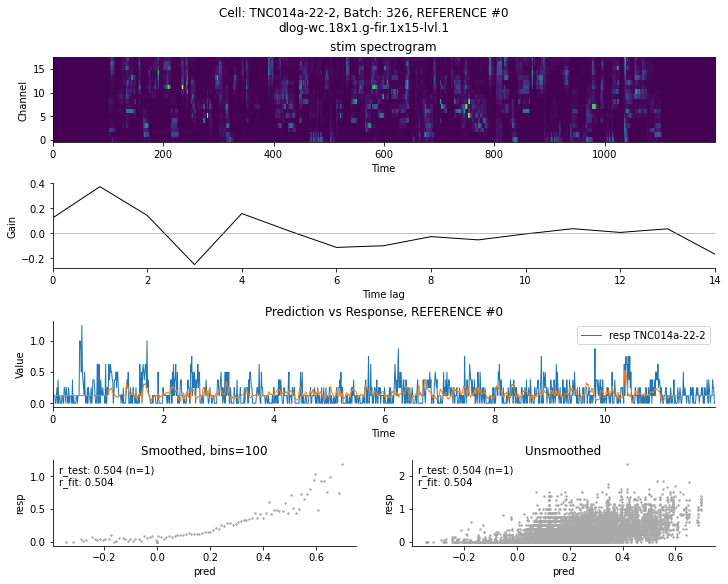

In [6]:
cellid = 'TNC014a-22-2'
batch = 326
modelspecname = 'dlog-wc.18x1.g-fir.1x15-lvl.1'
luke = 'env.fs200-ld-sev_dlog-fir.2x30x40-relu.40.f-wc.40xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3-newtf.n.lr1e4'
steven = 'ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x10.g-fir.1x25x10-wc.10xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.l2:4-dstrf'


meta = {'cellid': cellid, 'batch': 326, 'modelname': modelspecname, 'loadkey':'ozgf.fs100.ch18'}

xfspec = []

xfspec.append(['nems_lbhb.xform_wrappers.baphy_load_wrapper', meta])
xfspec.append(['nems.xforms.load_recordings', {}])
xfspec.append(['nems_lbhb.preprocessing.fix_cpn_epochs', {'sequence_only':True}])
xfspec.append(['nems.xforms.use_all_data_for_est_and_val', {}])
xfspec.append(['nems.xforms.average_away_stim_occurrences', {}])
# generate modelspec
xfspec.append(['nems.xforms.init_from_keywords',
               {'keywordstring': modelspecname, 'meta': meta}])
# do the fit
xfspec.append(['nems.xforms.fit_basic_init', {}])
xfspec.append(['nems.xforms.fit_basic', {}])

# test performance
xfspec.append(['nems.xforms.predict', {}])
xfspec.append(['nems.xforms.add_summary_statistics',    {}])

# GENERATE PLOTS
xfspec.append(['nems.xforms.plot_summary', {}])

# evaluate
ctx, log_xf = xforms.evaluate(xfspec)

# try to run some of my analysis on the fit

In [14]:
# signal_reliability(ctx['val']['resp'], r'\ASTIM_sequence*', threshold=0.1)
fig = plot_raw_pair(cellid, contexts=[8,10], probe=8, modelspec=modelspecname, ctx=ctx)
fig.show()

loading predicted response for TNC014a with modelspec
dlog-wc.18x1.g-fir.1x15-lvl.1
.... pff you bet. not yet implemented, using xform ctx


In [ ]:

xforms_kwargs = {}
xforms_init_context = {'cellid': cellid, 'batch': int(batch)}
recording_uri = None
kw_kwargs ={}

# parse modelname and assemble xfspecs for loader and fitter
load_keywords, model_keywords, fit_keywords = escaped_split(modelname, '_')

# Generate the xfspec, which defines the sequence of events
# to run through (like a packaged-up script)

# 0) set up initial context
if xforms_init_context is None:
    xforms_init_context = {}
if kw_kwargs is not None:
     xforms_init_context['kw_kwargs'] = kw_kwargs
xforms_init_context['keywordstring'] = model_keywords
xforms_init_context['meta'] = meta
xforms_lib.kwargs = xforms_init_context.copy()

xfspec = [['nems.xforms.init_context', xforms_init_context]]

# 1) Load the data
xfspec.extend(xhelp._parse_kw_string(load_keywords, xforms_lib))

# 2) generate a modelspec
xfspec.append(['nems.xforms.init_from_keywords', {'registry': keyword_lib}])

# 3) fit the data
xfspec.extend(xhelp._parse_kw_string(fit_keywords, xforms_lib))

# 4) add some performance statistics
if not _xform_exists(xfspec, 'nems.xforms.predict'):
    xfspec.append(['nems.xforms.predict', {}])

# 5) add some performance statistics (optional)
if not _xform_exists(xfspec, 'nems.xforms.add_summary_statistics'):
    xfspec.append(['nems.xforms.add_summary_statistics', {}])

# 6) generate plots (optional)
if autoPlot and not _xform_exists(xfspec, 'nems.xforms.plot_summary'):
    xfspec.append(['nems.xforms.plot_summary', {}])
